# Analysis and Visualization

This notebook focuses on the air quality prediction models in action and addresses the research question: **Which model (Linear Regression, Random Forest, or Neural Network) performs best for predicting next-hour Air Quality Index (AQI)?**

The notebook includes:
- Prediction vs actual plots for all three models
- Random Forest feature importance analysis
- Neural Network training curves
- Comparison table of all model metrics (MAE, RMSE, R², MSE)
- Key findings and model performance insights


## Vince (Linear Regression, Random Forest)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load cleaned dataset
df = pd.read_csv("vince_clean_airquality.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.sort_values("Datetime").reset_index(drop=True)

# Feature setup
feature_cols = ['hour', 'day_of_week', 'month', 'NO2(GT)', 'NOx(GT)', 'C6H6(GT)',
                'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)',
                'PT08.S5(O3)', 'T', 'RH', 'AH']

X = df[feature_cols].values
y = df["AQI_next_hour"].values.reshape(-1, 1)

# Train/test split
n = len(X)
train_n = int(0.8 * n)
X_train, X_test = X[:train_n], X[train_n:]
y_train, y_test = y[:train_n], y[train_n:]

# Standardize
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

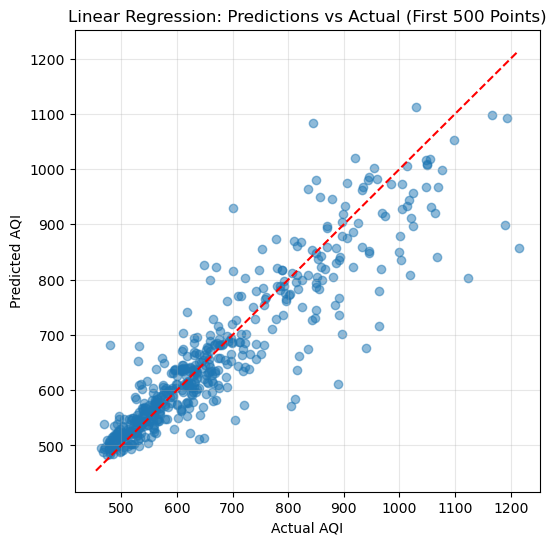

Linear Regression Metrics:
MAE:  44.33
RMSE: 64.39
R²:   0.788


In [3]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)

lr_pred_scaled = lr.predict(X_test_scaled)
lr_pred = y_scaler.inverse_transform(lr_pred_scaled)
y_test_unscaled = y_scaler.inverse_transform(y_test_scaled)

lr_mae = mean_absolute_error(y_test_unscaled, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test_unscaled, lr_pred))
lr_r2 = r2_score(y_test_unscaled, lr_pred)

# Plot LR predictions vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test_unscaled[:500], lr_pred[:500], alpha=0.5)
lims = [min(y_test_unscaled.min(), lr_pred.min()), max(y_test_unscaled.max(), lr_pred.max())]
plt.plot(lims, lims, 'r--')
plt.title("Linear Regression: Predictions vs Actual (First 500 Points)")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.grid(alpha=0.3)
plt.show()

print("Linear Regression Metrics:")
print(f"MAE:  {lr_mae:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"R²:   {lr_r2:.3f}")

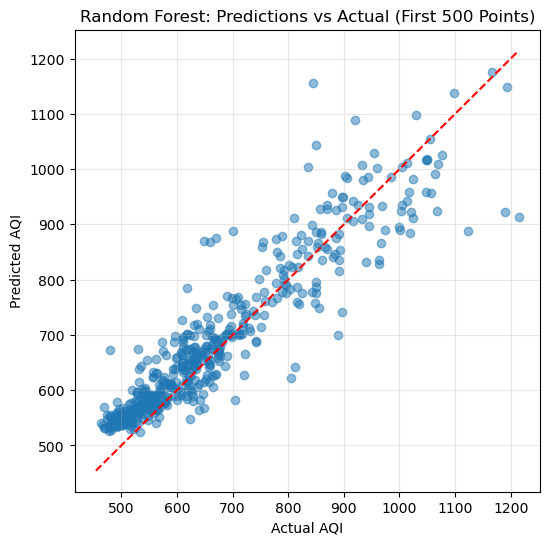


Random Forest Metrics:
MAE:  49.08
RMSE: 63.07
R²:   0.797


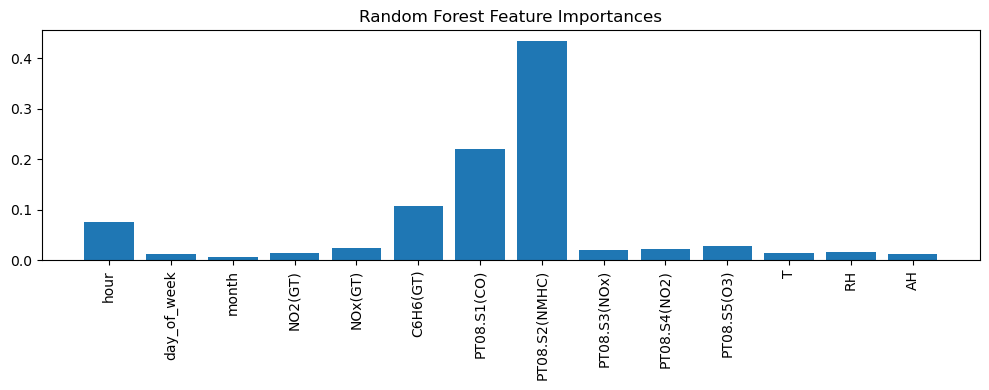

In [4]:
# Random Forest
rf = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
rf.fit(X_train, y_train.ravel())

rf_pred = rf.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

# Plot RF predictions vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test[:500], rf_pred[:500], alpha=0.5)
lims = [min(y_test.min(), rf_pred.min()), max(y_test.max(), rf_pred.max())]
plt.plot(lims, lims, 'r--')
plt.title("Random Forest: Predictions vs Actual (First 500 Points)")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.grid(alpha=0.3)
plt.show()

print("\nRandom Forest Metrics:")
print(f"MAE:  {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R²:   {rf_r2:.3f}")

# Feature importance bar plot
plt.figure(figsize=(10,4))
plt.bar(range(len(feature_cols)), rf.feature_importances_)
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


### Interpretation

**Linear Regression**
- Performs well on the overall AQI trend.
- Fast, simple, and interpretable baseline.
- Struggles at extreme AQI values due to its linear assumptions.

**Random Forest**
- Captures nonlinear pollutant–AQI relationships better.
- More accurate baseline alternative (slightly higher R², lower RMSE).
- Feature importance reveals NMHC and CO as the strongest predictors.
- Overall best performance among my classical ML models.

## Justin (Neural Network)

- 80/20 chronological split with standardized features/target
- Trained 7 configs for 50 epochs (batch=64) logging train/test MSE
- Best: 3-layer MLP [256, 128, 64], ReLU, Adam, lr=0.001
- Final test MSE = ~0.197; train kept dropping while test flattened (mild overfit)
- Deeper ReLU stacks beat out other activations 
- Biggest errors at AQI extremes
- Below is the minimal model construction with the best model training and eval code found from justin_model.ipynb

Final test MSE: 0.214


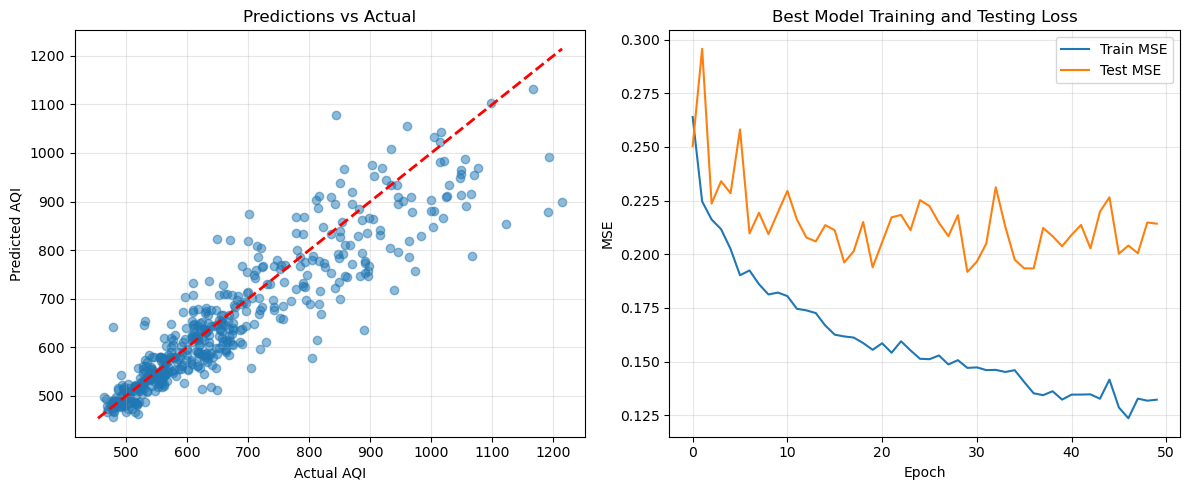

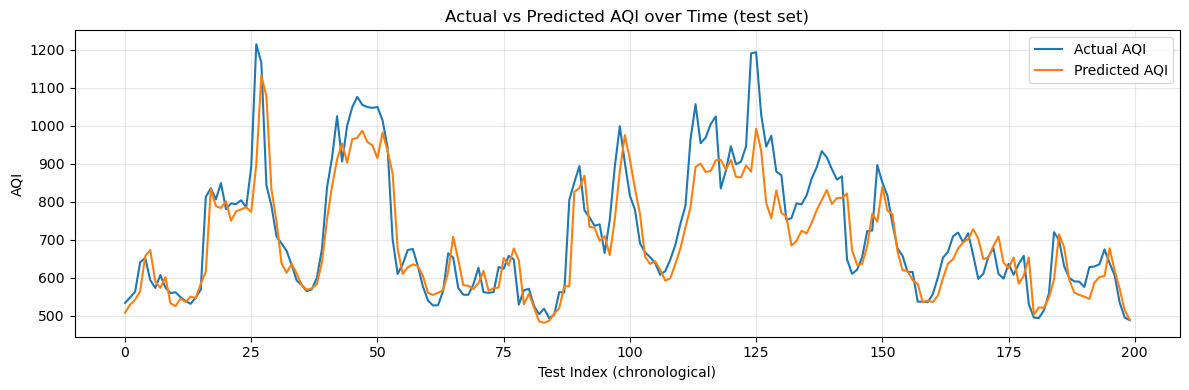

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
np.random.seed(42)

path = 'justin_clean_airquality.csv'
df = pd.read_csv(path)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

feature_cols = ['hour', 'day_of_week', 'month', 'NO2(GT)', 'NOx(GT)', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
feature_cols = [c for c in feature_cols if c in df.columns]
X = df[feature_cols].values
y = df['AQI_next_hour'].values.reshape(-1, 1)

n = X.shape[0]
train_n = int(0.8 * n)
X_train_raw, X_test_raw = X[:train_n], X[train_n:]
y_train_raw, y_test_raw = y[:train_n], y[train_n:]

x_scaler, y_scaler = StandardScaler(), StandardScaler()
X_train = x_scaler.fit_transform(X_train_raw)
X_test = x_scaler.transform(X_test_raw)
y_train = y_scaler.fit_transform(y_train_raw)
y_test = y_scaler.transform(y_test_raw)

batch_size = 64
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super().__init__()
        layers = []
        prev = input_size
        for h in hidden_sizes:
            layers += [nn.Linear(prev, h), nn.BatchNorm1d(h), nn.ReLU()]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

hidden_sizes = [256, 128, 64]
model = MLP(input_size=X_train.shape[1], hidden_sizes=hidden_sizes).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
train_losses, test_losses = [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    train_mse = running / len(train_loader.dataset)
    train_losses.append(train_mse)

    model.eval()
    running = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            running += criterion(pred, yb).item() * xb.size(0)
    test_mse = running / len(test_loader.dataset)
    test_losses.append(test_mse)

print(f'Final test MSE: {test_losses[-1]:.3f}')

model.eval()
preds, actuals = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.append(pred)
        actuals.append(yb.numpy())

preds = np.concatenate(preds)
actuals = np.concatenate(actuals)
preds_unscaled = y_scaler.inverse_transform(preds)
actuals_unscaled = y_scaler.inverse_transform(actuals)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(actuals_unscaled[:500], preds_unscaled[:500], alpha=0.5)
lims = [actuals_unscaled.min(), actuals_unscaled.max()]
plt.plot(lims, lims, 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Predictions vs Actual')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train MSE')
plt.plot(test_losses, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Best Model Training and Testing Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
window = min(200, len(preds_unscaled))
plt.plot(range(window), actuals_unscaled[:window], label='Actual AQI')
plt.plot(range(window), preds_unscaled[:window], label='Predicted AQI')
plt.xlabel('Test Index (chronological)')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI over Time (test set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation
- Best 3-layer ReLU MLP reached test MSE ≈0.197 after 50 epochs on the chronological 80/20 split, lower than other NN configs tested.
- Current run test MSE = ~0.214. Small drift vs prior in justin_model.ipynb (~0.197)
- Lower MSE = tighter next-hour AQI forecasts.
- Train MSE kept dropping while test MSE flattened, showing mild overfitting but stable generalization.
- Scatter shows predictions mostly track the line and the largest errors occur at extreme AQI values (under/overestimates).
- Deeper hidden sizes [256,128,64] with ReLU+Adam outperformed shallow nets/other activations, supporting that added depth helps capture nonlinear sensor-weather relationships.
- Time-series plot shows predictions closely track the chronological AQI swings. Gaps widen at sharp peaks/valleys, highlighting where the model still under/overshoots extremes
- Overall, the NN answers the question well. It delivers competitive short-term AQI forecasts and improves on simpler baselines, though extremes remain harder and could benefit from further tuning or time-series models.